# Capacity Building
## Prerequisites
- Some basic understanding of Python variables, data types, looping, conditionals and functions will be of benefit.
- Completion of  01-basic-model.ipynb, 02-flow-types.ipynb

## A practical application

So far, we've looked at creating a compartmental model, adding flows, requesting derived outputs, and using different solvers and stratifications.<br> Today we take a break from theory to look at the application of these concepts to an epidemic.




## Data inputs
### Imports

In [124]:
# Install the summer package
# Pip is Python's standard package manager

# %pip install summerepi


In [125]:
# Python standard library imports come first
from datetime import datetime, timedelta
from typing import List

# Then external package imports
import pandas as pd
import numpy as np
from summer import CompartmentalModel
from summer import Stratification
from matplotlib import pyplot as plt

# This time, we're going to do some interactive plotting!
pd.options.plotting.backend = "plotly"

# Define constants
GITHUB_MOH = "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/"

MOH_FILES = [
    "cases_malaysia",
    "deaths_malaysia",
    "hospital",
    "icu",
    "cases_state",
    "deaths_state",
]

COVID_BASE_DATE = datetime(2019, 12, 31)

region = "Malaysia"


### Utility functions

In [126]:
def fetch_mys_data(base_url: str, file_list: List[str]) -> pd.DataFrame:
    """
    Request files from MoH and combine them into one data frame.
    """
    a_list = []
    for file in file_list:
        data_type = file.split("_")[0]
        df = pd.read_csv(base_url + file + ".csv")
        df["type"] = data_type
        a_list.append(df)
    df = pd.concat(a_list)

    return df


### Get data
Now call the `fetch_mys_data` function and pass it the MoH url.<br>

In [127]:
df = fetch_mys_data(GITHUB_MOH, MOH_FILES)

# Same preprocessing steps as in notebook 1
df.loc[df["state"].isna(), "state"] = "Malaysia"
df["date"] = pd.to_datetime(df["date"])
df["date_index"] = (df["date"] - COVID_BASE_DATE).dt.days

# Configure mask for analysis
mask = (df["state"] == region) & (df["type"] == "cases")

# Also download the population data
population_url = (
    "https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/static/population.csv"
)
df_pop = pd.read_csv(population_url)
initial_population = df_pop[df_pop["state"] == region]["pop"][0]


In [128]:
start_date = datetime(2021, 1, 1)  # Define the start date
end_date = start_date + timedelta(days=300)  # Define the duration

# Integer representation of the start and end dates.
start_date_int = (start_date - COVID_BASE_DATE).days
end_date_int = (end_date - COVID_BASE_DATE).days


In [129]:
notifications_target = df[mask][start_date_int:end_date_int]["cases_new"]


In [130]:
def plot_comparison(label_a: str, data_a: pd.Series, label_b: str, data_b: pd.Series, title: str):
    # Visualize the results.
    subplot = {"title": title, "xlabel": "Days", "ylabel": "Value"}
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw=subplot)

    ax.plot(data_a.index, data_a)
    ax.plot(data_b.index, data_b)

    ax.legend([label_a, label_b])


## Flows
### Define flows

In [131]:
def contact_rate(time, computed_values):
    return 2


In [132]:
def progression_rate(time, computed_values):
    return 0.1


In [133]:
def recovery_rate(time, computed_values):
    return 0.1


In [134]:
def death_rate(time, computed_values):
    pass


In [135]:
def get_vaccination_flow_rate(flow, comp_names, comp_vals, flows, flow_rates, derived_values, time):
    """
    Returns the flow-rate of susceptible people who get vaccinated and become recovered.

    Args:
        flow: The flow object being run
        comp_names: List of compartment names (Compartment)
        comp_vals: Array of compartment values at this timestep
        flows: List of flow objects (used to calculate flow rates)
        flow_rates: Calculated flow rate for each non-function flow at this timestep
        time: Current timestep

    Returns: The flow rate (float)
    """
    if time < 450:
        # Vaccinate 500 people per day until day 450
        return 500
    elif 450 <= time < 500:
        # Vaccinate a tiny fraction of the population per day until day 500
        return 0.00001 * comp_vals.sum()
    else:
        # After day 500 stop vaccinations, because we ran out of money
        return 0


In [136]:
# Create a parameters dictionary - we'll reuse this whenever building the model
parameters = {
    "contact_rate": contact_rate,
    "progression_rate": progression_rate,
    "recovery_rate": recovery_rate,
    "vaccination_flow_rate": get_vaccination_flow_rate,
    "death_rate": 0.1,
}


## Stratifications
### Define stratifications

In [137]:
def get_age_stratification() -> Stratification:
    # Create the stratification
    strata=["young", "old"]
    strat = Stratification(name="age", strata=strata, compartments=["S", "E", "I", "R"])

    # Create our population split dictionary, whose keys match the strata
    pop_split = {"young": 0.25, "old": 0.75}

    # Set a population distribution
    strat.set_population_split(pop_split)

    return strat


In [138]:
def get_severity_strat() -> Stratification:
    # Create a stratification named 'severity', applying to the infectious, which
    # splits that compartment into 'asymptomatic', 'mild' and 'severe'.
    severity_strata = ["asymptomatic", "mild", "severe"]

    # Notice the new argument ["I"] for the compartment parameter.
    severity_strat = Stratification(name="severity", strata=severity_strata, compartments=["I"])

    # Set a population distribution - everyone starts out asymptomatic.
    severity_strat.set_population_split({"asymptomatic": 1.0, "mild": 0, "severe": 0})
    
    return severity_strat

In [139]:
# Add an adjustment to the 'progression' flow for young & old people.

young_progression_adjustments = {
    "asymptomatic": 0.5,  # 50% of cases are asympt.
    "mild": 0.4,  # 40% of cases are mild.
    "severe": 0.1,  # 10% of cases are severe.
}

old_progression_adjustments = {
    "asymptomatic": 0.1,  # 10% of cases are asympt.
    "mild": 0.4,  # 40% of cases are mild.
    "severe": 0.5,  # 50% of cases are severe.
}


In [140]:
    all_age_infection_death_flow_adjustments = {
        "asymptomatic": 0.5,
        "mild": None,
        "severe": 1.5,
    }

    all_age_infectiousness_adjustments = {
        "asymptomatic": 0.5,
        "mild": None,
        "severe": 1.5,
    }

### Build stratification

In [141]:
# Get the age stratification
age_strat = get_age_stratification()

# Get the severity stratification
severity_strat = get_severity_strat()

In [142]:
severity_strat.set_flow_adjustments(
    "progression",
    young_progression_adjustments,
    source_strata={
        "age": "young"
    },  # Only apply this adjustment to flows of young people
)

severity_strat.set_flow_adjustments(
    "progression",
    old_progression_adjustments,
    source_strata={"age": "old"},  # Only apply this adjustment to flows of old people
)

In [143]:
severity_strat.set_flow_adjustments(
    "infection_death",
    all_age_infection_death_flow_adjustments
)

# Adjust infectiousness levels (for all age groups)
severity_strat.add_infectiousness_adjustments(
    "I",
    all_age_infectiousness_adjustments
)

## Define a model

Recall the `build_base_model` wrapper function from the last training session.

In [144]:
def build_base_model() -> CompartmentalModel:
    model = CompartmentalModel(
        times=(start_date_int, end_date_int),
        compartments=["S", "E", "I", "R"],
        infectious_compartments=["I"],
    )

    model.set_initial_population(distribution={"S": initial_population - 100, "E": 0, "I": 100})

    return model


In [145]:
def build_model_with_flows(parameters: dict) -> CompartmentalModel:

    # This base model does not take parameters, but have a think about how it might...
    model = build_base_model()

    # Susceptible people can get infected.
    model.add_infection_frequency_flow(
        name="infection", contact_rate=parameters["contact_rate"], source="S", dest="E"
    )
    # Expose people transition to infected.
    model.add_transition_flow(
        name="progression",
        fractional_rate=parameters["progression_rate"],
        source="E",
        dest="I",
    )

    # Infectious people recover.
    model.add_transition_flow(
        name="recovery",
        fractional_rate=parameters["recovery_rate"],
        source="I",
        dest="R",
    )

    # Add an infection-specific death flow to the I compartment.
    model.add_death_flow(name="infection_death", death_rate=parameters["death_rate"], source="I")

    
    model.add_function_flow(
        "vaccination", flow_rate_func=parameters["vaccination_flow_rate"], source="S", dest="R"
    )

    # Importantly, we will also request an output for the 'progression' flow, and name this 'notifications'
    # This will be available after a model run using the get_derived_outputs_df() method

    model.request_output_for_flow("notifications", "progression")

    return model


In [146]:
model = build_model_with_flows(parameters)
# Apply age, then severity stratifications
model.stratify_with(age_strat)
model.stratify_with(severity_strat)

In [147]:
# Build and run model with no stratifications
#model = build_model_with_flows(parameters)
model.run()

# Plot compartments
outputs_df = model.get_outputs_df()
outputs_df.plot()


In [148]:
model_derived_outputs = model.get_derived_outputs_df()

In [149]:
model_derived_outputs.plot()

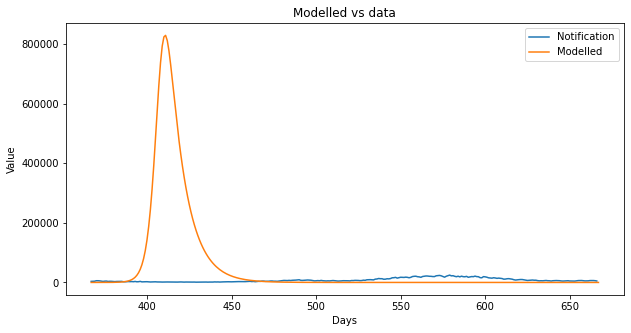

In [150]:
proportion_of_cases_detected = 0.5

plot_comparison("Notification", 
                notifications_target, 
                "Modelled",
                model_derived_outputs["notifications"] * proportion_of_cases_detected,
                "Modelled vs data")